In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal =sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
file_path= r"C:\Users\Wsiwale\Desktop\Dataset\archive\PJME_hourly.csv"
df = pd.read_csv(file_path)
df = df.set_index("Datetime")
df.index=pd.to_datetime(df.index)

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [6]:
color_pal =sns.color_palette()

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

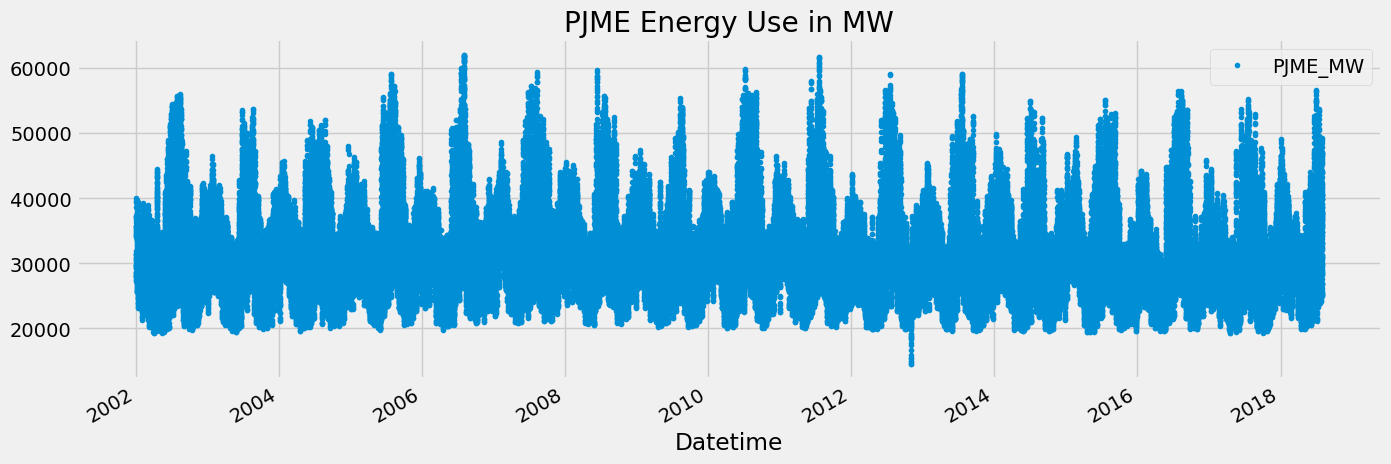

In [7]:
df.plot(style ='.', figsize = (15, 5), color = color_pal[0], title ='PJME Energy Use in MW')

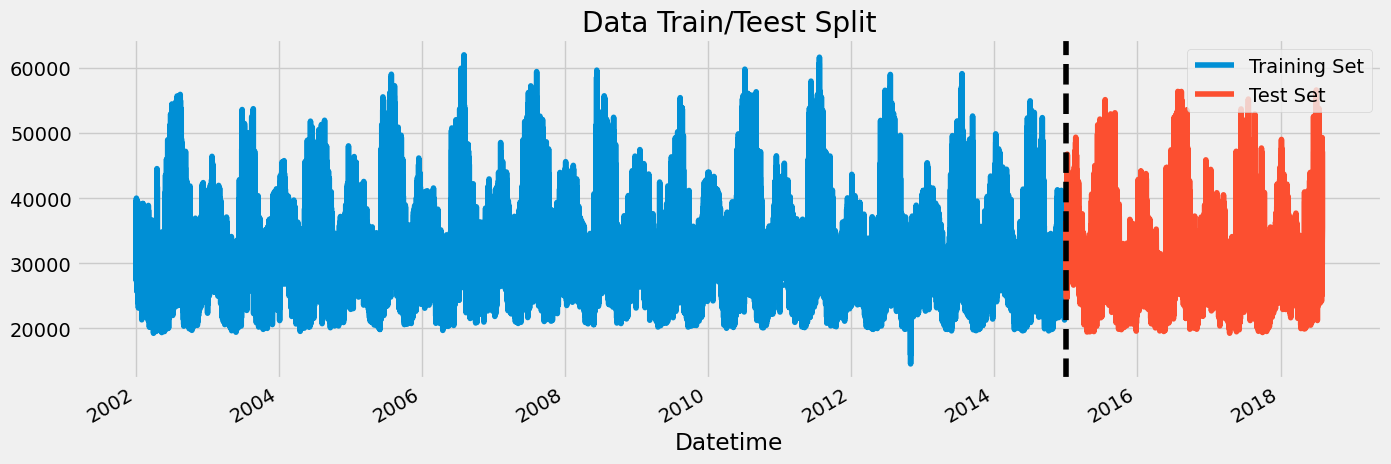

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label = 'Training Set', title='Data Train/Teest Split')
test.plot(ax=ax, label = 'Test Set')
ax.axvline('01-01-2015', color = 'black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

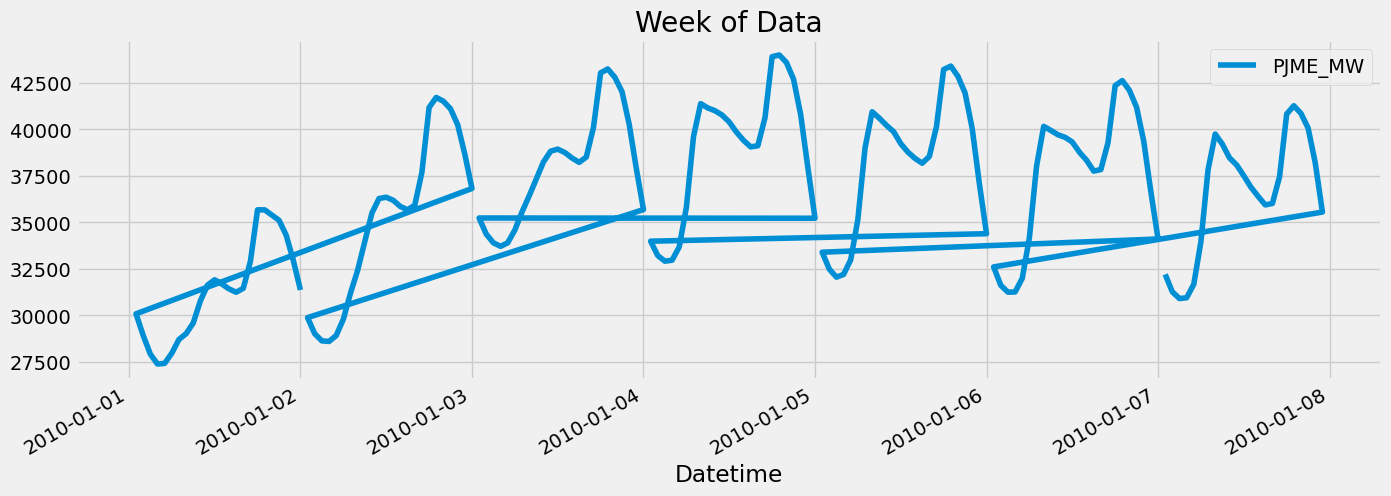

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index <'01-08-2010')].plot(figsize= (15, 5), title = 'Week of Data')
plt.show()

In [10]:
def create_features(df):
    df= df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek  # Changed to `dayofweek`
    df['quarter'] = df.index.quarter  # Fixed typo `qaurter` to `quarter`
    df['month'] = df.index.month
    df['year'] = df.index.year  # Fixed typo `yeaar` to `year`
    df['dayofyear'] = df.index.dayofyear  # Corrected to `dayofyear`
    return df  # Proper indentation

df = create_features(df)

In [11]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


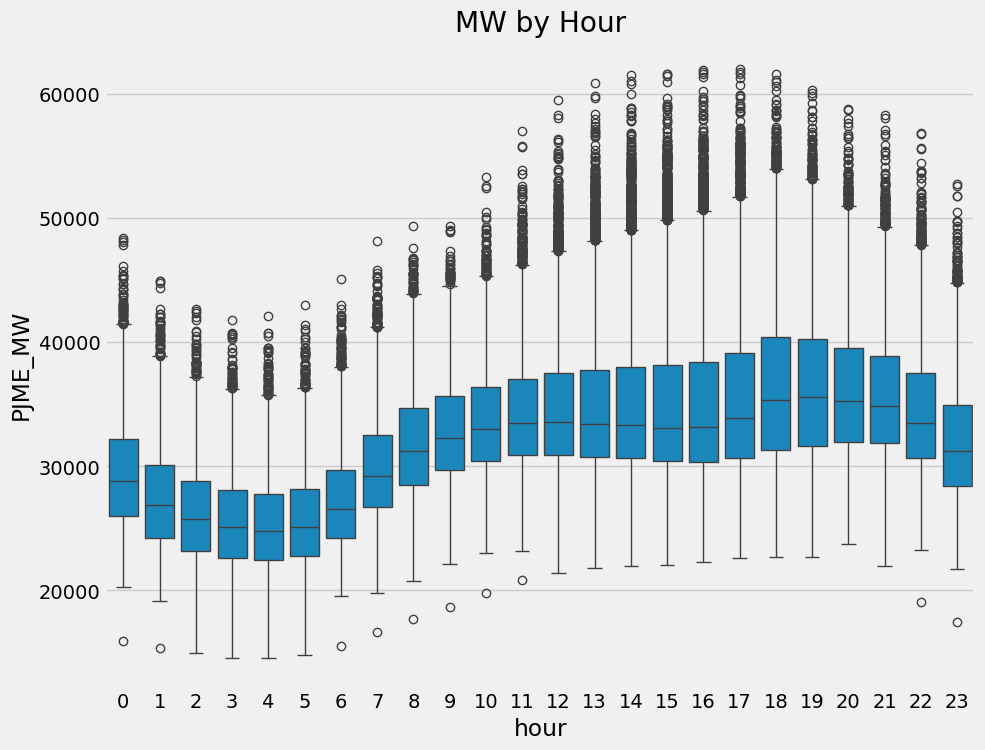

In [12]:
# Visualise our feature / Target relationship
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'hour' is the correct column name
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')  # Changed 'hours' to 'hour'
ax.set_title('MW by Hour')
plt.show()

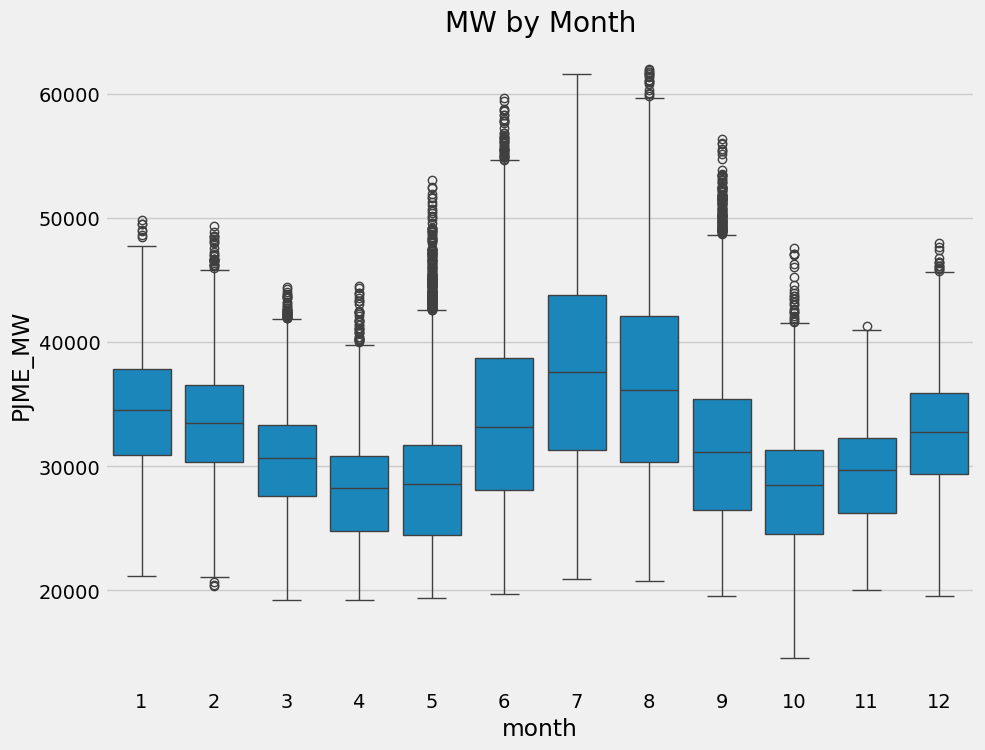

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'month' is the correct column name
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')  # Use 'month' if it was created earlier
ax.set_title('MW by Month')
plt.show()

Training A Model

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET = ['PJME_MW']

In [15]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [16]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Feature importance

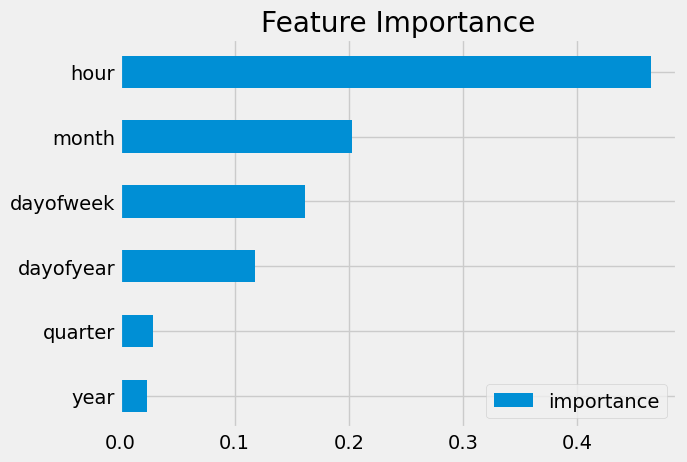

In [17]:
fi= pd.DataFrame(data=reg.feature_importances_, index = reg.feature_names_in_, columns = ['importance'])
fi.sort_values('importance').plot(kind ='barh', title='Feature Importance')
plt.show()

Forecast on Test

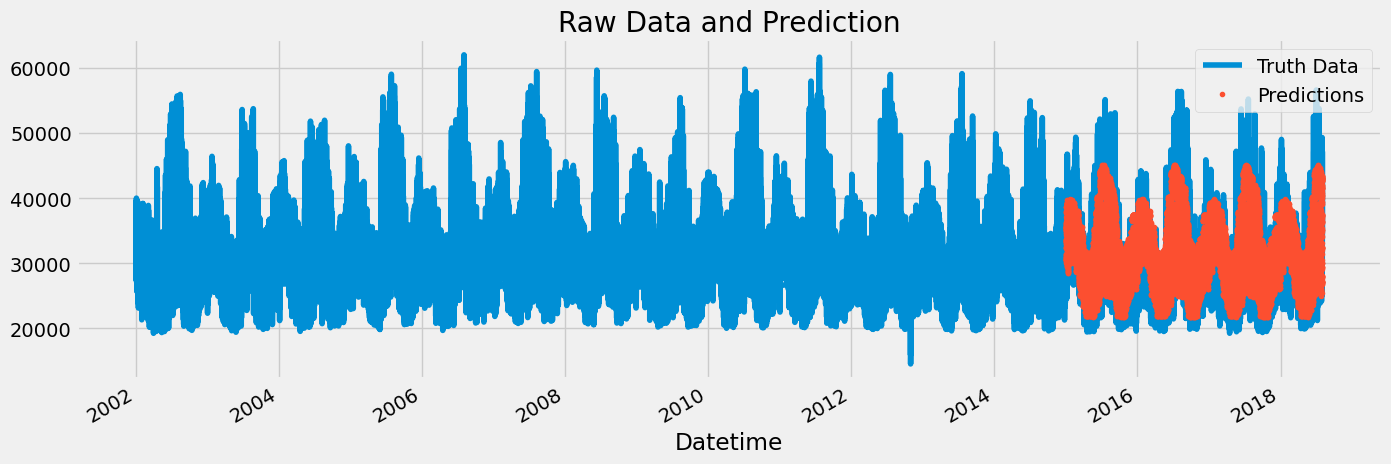

In [18]:
test['prediction'] = reg.predict(X_test)

# Use 'prediction' instead of 'predictions'
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plot the results
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

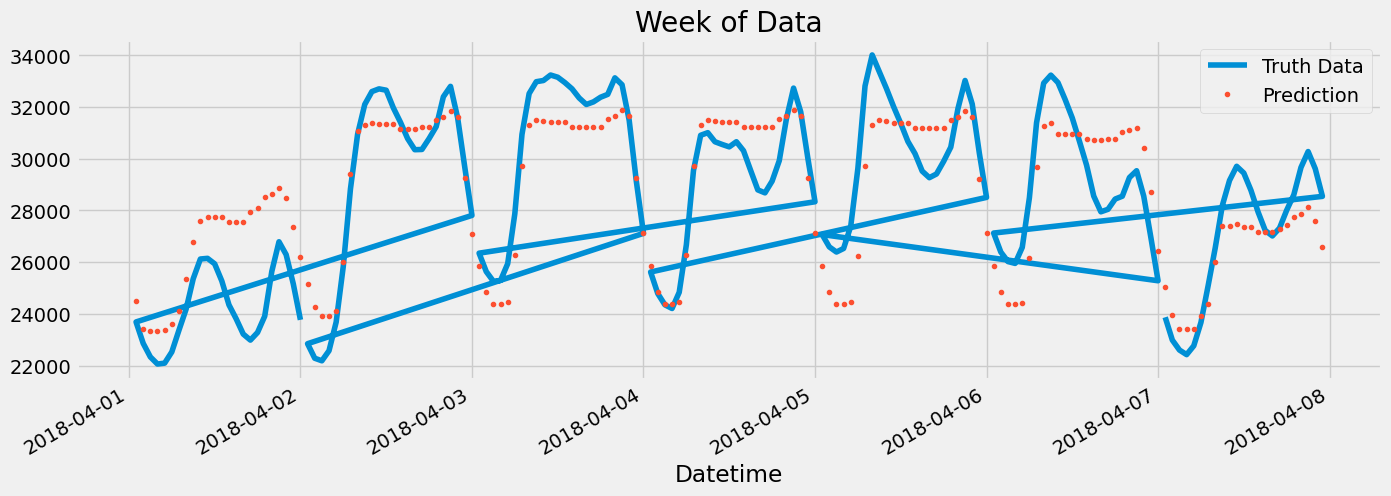

In [19]:
# Plot the 'PJME_MW' column
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018'), 'PJME_MW'] \
    .plot(figsize=(15, 5), title='Week of Data')

# Plot the 'prediction' column on the same axis
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018'), 'prediction'] \
    .plot(ax=ax, style='.')

# Add legend and show the plot
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [20]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3741.03
